# Data Wrangling

### Table of Contents

* [0.0 Data Cleaning](#data_clean)
    * [0.1 Missing Values](#missing_values)
    * [0.2 Additional Drops](#additional_drops)
    * [0.3 Imputation](#imputation)
    * [0.4 Standardization](#standardization)
    * [0.5 Preview](#preview)
    * [0.6 EDA](#eda)
* [1.0 Feature Engineering](#feat_eng)
    * [1.1 Date Features](#date_feat)
    * [1.2 Range Features](#range_feat)
    * [1.3 Target ](#target)
* [Output](#output) 

## 0.0 Data Cleaning <a class="anchor" id="#data_clean"></a>

In [20]:
# Reload .py auxiliary file
%load_ext autoreload
%autoreload 2

# Imports
import matplotlib.ticker as mticker
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import project_utils as pu
import seaborn as sns
import warnings

# Options
%matplotlib inline
pd.pandas.set_option('display.max_columns', None)
warnings.filterwarnings('ignore')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [21]:
# Load the dataset into a pandas dataframe
df = pd.read_csv('./accepted_2007_to_2018Q4.csv',
                 encoding='utf-8',
                 na_values=[' ', 'ANY', 'NONE', 'OTHER'],
                 parse_dates=['issue_d', 'earliest_cr_line'],
                 skipinitialspace = True)

In [22]:
# Unique values of target value
df['loan_status'].unique()

array(['Fully Paid', 'Current', 'Charged Off', 'In Grace Period',
       'Late (31-120 days)', 'Late (16-30 days)', 'Default', nan,
       'Does not meet the credit policy. Status:Fully Paid',
       'Does not meet the credit policy. Status:Charged Off'],
      dtype=object)

In [23]:
# Filter only records with information about completed loans
df = df[df['loan_status'].isin(['Fully Paid', 'Charged Off', 'Default'])]

### 0.1 Missing Values <a class="anchor" id="missing_values"></a>

In [24]:
# Percentage of null in every feature
null_percentage = df.isnull().sum() / df.shape[0] * 100

# List of features having more than 60% null
empty_cols = null_percentage[null_percentage > 60].keys()

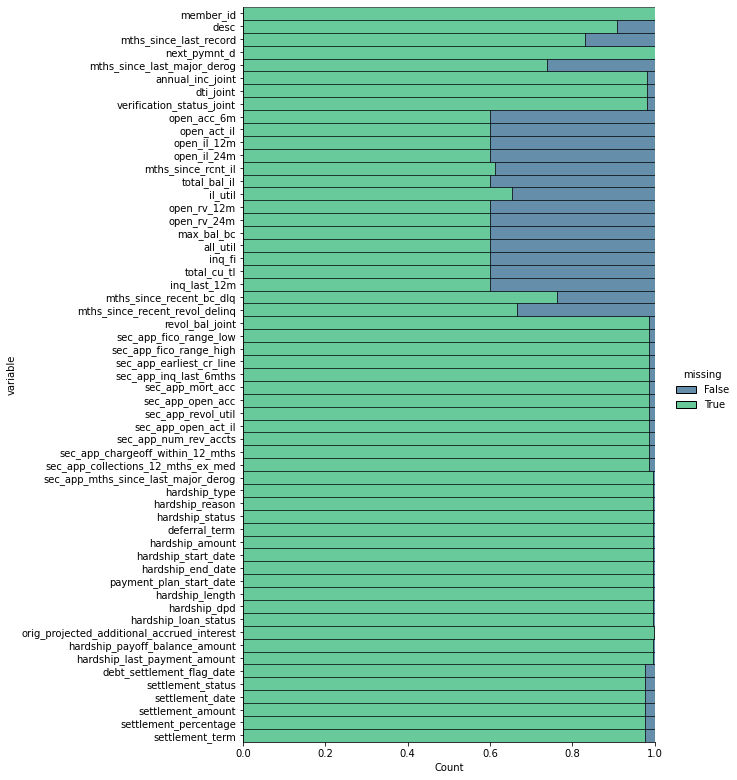

In [6]:
# Visualize features having more than 60% null
#plt.figure(figsize=(10, 40))

sns.displot(data=df[empty_cols].isna().melt(value_name="missing"),
            y="variable",
            hue="missing",
            multiple="fill",
            aspect=2,
            palette='viridis')

plt.gcf().set_size_inches(10, 12)

plt.savefig("./output/missing_data.png", bbox_inches='tight', dpi=600)

In [25]:
# Drop features having more missing values than the threshold empirically set
df.drop(empty_cols, axis=1, inplace=True)

# Drop observations having more missing values than 90% null
df.dropna(axis=0, thresh=df.shape[1]*0.1, inplace=True)

### 0.2 Additional Drops <a class="anchor" id="additional_drops"></a>

In [26]:
# Features that couldn't be used because:
cols_to_drop = ['id', # id column
                'url', # id column
                'grade', # biased by platform
                'sub_grade', # biased by platform
                'emp_title', # fairness
                'zip_code', # fairness
                'addr_state', # fairness
                'title', # description
                'out_prncp', # data leakage
                'out_prncp_inv', # data leakage
                'total_pymnt', # data leakage
                'total_pymnt_inv', # data leakage
                'total_rec_prncp', # data leakage
                'total_rec_int', # data leakage
                'total_rec_late_fee', # data leakage
                'recoveries', # data leakage
                'collection_recovery_fee', # data leakage
                'last_pymnt_d', # data leakage
                'last_pymnt_amnt', # data leakage
                'debt_settlement_flag', # data leakage
                'last_credit_pull_d', # data leakage
                'last_fico_range_high', # data leakage
                'last_fico_range_low' # data leakage
               ]

# Drop columns listed above
df.drop(cols_to_drop, axis=1, inplace=True)

### 0.3 Imputation <a class="anchor" id="imputation"></a>

In [27]:
# Impute 0 for numerical columns and 'na' for categorical features
df = df.fillna(0).fillna('na')

### 0.4 Standardization <a class="anchor" id="standardization"></a>

In [28]:
# All numeric features
num_columns = list(df.select_dtypes(include=['float64', 'Int64']).columns)

# Needed float type features
float_columns = ['int_rate',
                'dti',
                'revol_util',
                'out_prncp_inv',
                'dti_joint',
                'il_util',
                'bc_util',
                'pct_tl_nvr_dlq',
                'percent_bc_gt_75',
                'sec_app_revol_util']

# Convert selected features to int
df = pu.convert_column_type(dataframe=df, dtype=np.int64, columns=num_columns, excl_list=float_columns)

### 0.5 Preview <a class="anchor" id="preview"></a>

In [29]:
df.head(3)

,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,pymnt_plan,purpose,dti,delinq_2yrs,earliest_cr_line,fico_range_low,fico_range_high,inq_last_6mths,mths_since_last_delinq,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,collections_12_mths_ex_med,policy_code,application_type,acc_now_delinq,tot_coll_amt,tot_cur_bal,total_rev_hi_lim,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,bc_util,chargeoff_within_12_mths,delinq_amnt,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,mths_since_recent_inq,num_accts_ever_120_pd,num_actv_bc_tl,num_actv_rev_tl,num_bc_sats,num_bc_tl,num_il_tl,num_op_rev_tl,num_rev_accts,num_rev_tl_bal_gt_0,num_sats,num_tl_120dpd_2m,num_tl_30dpd,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,hardship_flag,disbursement_method
0,3600,3600,3600,36 months,13.99,123,10+ years,MORTGAGE,55000,Not Verified,2015-12-01,Fully Paid,n,debt_consolidation,5.91,0,2003-08-01,675,679,1,30,7,0,2765,29.7,13,w,0,1,Individual,0,722,144904,9300,4,20701,1506,37.2,0,0,148,128,3,3,1,4,4,2,2,4,2,5,3,4,9,4,7,0,0,0,3,76.9,0.0,0,0,178050,7746,2400,13734,N,Cash
1,24700,24700,24700,36 months,11.99,820,10+ years,MORTGAGE,65000,Not Verified,2015-12-01,Fully Paid,n,small_business,16.06,1,1999-12-01,715,719,4,6,22,0,21470,19.2,38,w,0,1,Individual,0,0,204396,111800,4,9733,57830,27.1,0,0,113,192,2,2,4,2,0,0,5,5,13,17,6,20,27,5,22,0,0,0,2,97.4,7.7,0,0,314017,39475,79300,24667,N,Cash
2,20000,20000,20000,60 months,10.78,432,10+ years,MORTGAGE,63000,Not Verified,2015-12-01,Fully Paid,n,home_improvement,10.78,0,2000-08-01,695,699,0,0,6,0,7869,56.2,18,w,0,1,Joint App,0,0,189699,14000,6,31617,2737,55.9,0,0,125,184,14,14,5,101,10,0,2,3,2,4,6,4,7,3,6,0,0,0,0,100.0,50.0,0,0,218418,18696,6200,14877,N,Cash


In [30]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1345350 entries, 0 to 2260697
Data columns (total 71 columns):
 #   Column                      Non-Null Count    Dtype         
---  ------                      --------------    -----         
 0   loan_amnt                   1345350 non-null  int64         
 1   funded_amnt                 1345350 non-null  int64         
 2   funded_amnt_inv             1345350 non-null  int64         
 3   term                        1345350 non-null  object        
 4   int_rate                    1345350 non-null  float64       
 5   installment                 1345350 non-null  int64         
 6   emp_length                  1345350 non-null  object        
 7   home_ownership              1345350 non-null  object        
 8   annual_inc                  1345350 non-null  int64         
 9   verification_status         1345350 non-null  object        
 10  issue_d                     1345350 non-null  datetime64[ns]
 11  loan_status             

### 0.6 EDA <a class="anchor" id="eda"></a>

In [31]:
# Measures of central tendency and dispersion (numerical features)
df.describe().transpose().apply(lambda x: x.apply('{0:.1f}'.format))

,count,mean,std,min,25%,50%,75%,max
loan_amnt,1345350.0,14420.0,8717.1,500.0,8000.0,12000.0,20000.0,40000.0
funded_amnt,1345350.0,14411.6,8713.2,500.0,8000.0,12000.0,20000.0,40000.0
funded_amnt_inv,1345350.0,14389.1,8715.5,0.0,7875.0,12000.0,20000.0,40000.0
int_rate,1345350.0,13.2,4.8,5.3,9.8,12.7,16.0,31.0
installment,1345350.0,437.6,261.5,4.0,248.0,375.0,580.0,1719.0
annual_inc,1345350.0,76247.6,69924.9,0.0,45780.0,65000.0,90000.0,10999200.0
dti,1345350.0,18.3,11.2,-1.0,11.8,17.6,24.1,999.0
delinq_2yrs,1345350.0,0.3,0.9,0.0,0.0,0.0,0.0,39.0
fico_range_low,1345350.0,696.2,31.9,625.0,670.0,690.0,710.0,845.0
fico_range_high,1345350.0,700.2,31.9,629.0,674.0,694.0,714.0,850.0


In [14]:
# Measures of frequency (categorical features)
df.describe(include = 'object').transpose()

,count,unique,top,freq
term,1345350,2,36 months,1020768
emp_length,1345350,12,10+ years,442209
home_ownership,1345350,4,MORTGAGE,665596
verification_status,1345350,3,Source Verified,521289
loan_status,1345350,3,Fully Paid,1076751
pymnt_plan,1345350,1,n,1345350
purpose,1345350,14,debt_consolidation,780342
initial_list_status,1345350,2,w,784041
application_type,1345350,2,Individual,1319544
hardship_flag,1345350,1,N,1345350


## 1.0 Feature Engineering <a class="anchor" id="feat_eng"></a>

### 1.1 Date Features <a class="anchor" id="date_feat"></a>

In [15]:
# Number of months since  borrower's earliest reported credit line was opened
# using issue date as reference
df['mths_since_earliest_cr_line'] = ((df.issue_d - df.earliest_cr_line) / np.timedelta64(1, 'M')).round()

In [16]:
# Convert to int the new feature
df = pu.convert_column_type(dataframe=df, dtype=np.int64, columns=['mths_since_earliest_cr_line'])

# Drop old feature
df.drop('earliest_cr_line', axis=1, inplace=True)

### 1.2 Range Features <a class="anchor" id="range_feat"></a>

In [17]:
# Create a range as new categories to employment length
new_range = {'0' : '2 or less years',
             '< 1 year' : '2 or less years',
             '1 year' : '2 or less years',
             '2 years' : '2 or less years',
             '3 years' : '2 < x <= 5 years',
             '4 years' : '2 < x <= 5 years',
             '5 years' : '2 < x <= 5 years',
             '6 years' : '5 < x <= 8 years',
             '7 years' : '5 < x <= 8 years',
             '8 years' : '5 < x <= 8 years',
             '9 years' : 'more than 8 years',
             '10+ years' : 'more than 8 years'}

df['emp_length'].replace(to_replace=new_range, inplace=True)

### 1.3 Target <a class="anchor" id="target"></a>

In [18]:
# Encode target variable
target = {'Fully Paid' : 1,
          'Charged Off' : 0,
          'Default' : 0}

df['target'] = df['loan_status'].replace(to_replace=target)

# Drop old variable
df.drop('loan_status', axis=1, inplace=True)

# Output <a class="anchor" id="output"></a>

In [19]:
df.to_csv('./output/p2p_cleaned.csv', index=False)